In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [6]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    override_params={
        'save_dir': '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode'
    }
)
assert len(gf.queue.remaining_genes) == 0

In [8]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

In [10]:
interactions = {}

for ct in adata.obs.cell_type.unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

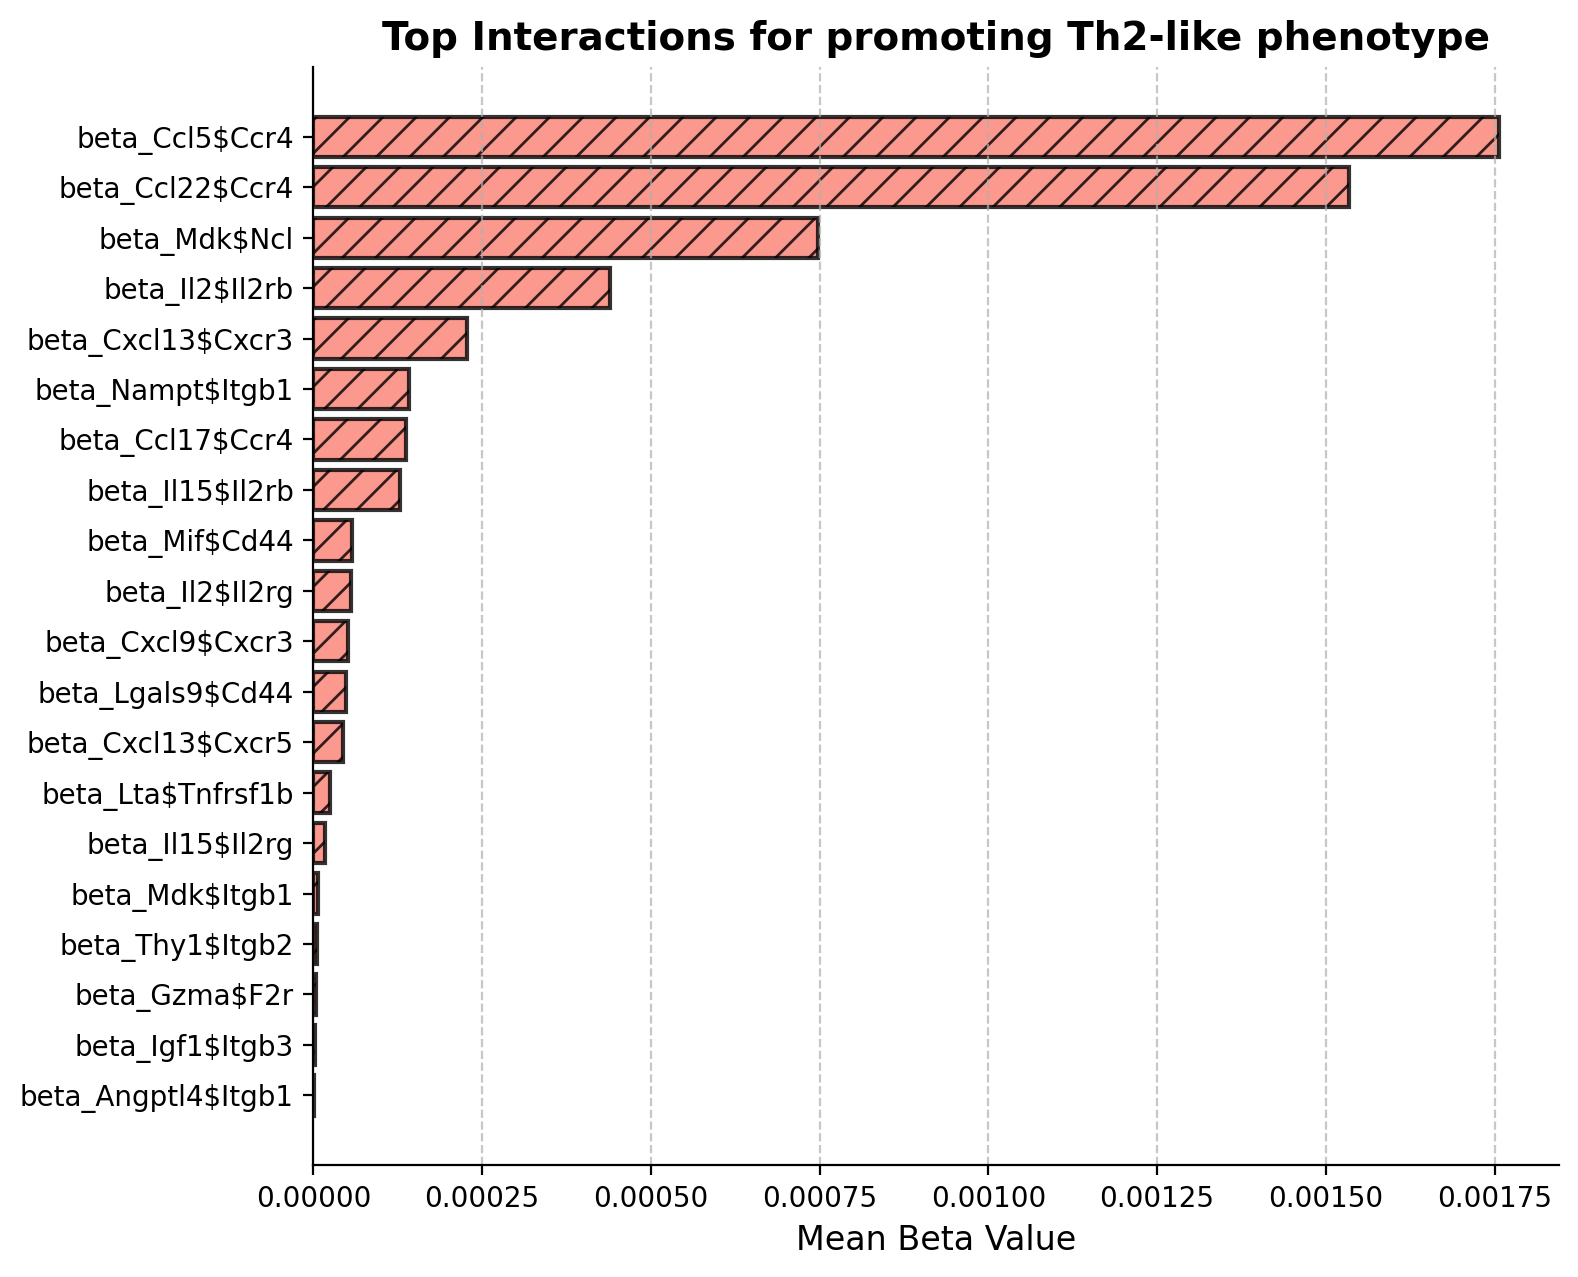

In [98]:
interactions_data = interactions['Th2'].query(
    "gene=='Il2ra' and not interaction.str.contains('C3')")
top_interactions = interactions_data[['interaction', 'beta']].groupby('interaction').sum()
top_interactions = top_interactions.sort_values(by='beta', ascending=False).head(20)[::-1]

fig, ax = plt.subplots(figsize=(8, 6.5), dpi=100)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//', linewidth=1.5)
ax.set_xlabel('Mean Beta Value', fontsize=12)
ax.set_title('Top Interactions for promoting Th2-like phenotype', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()